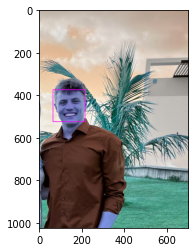

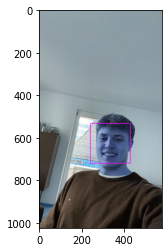

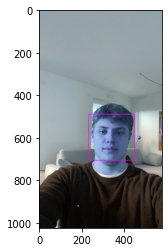

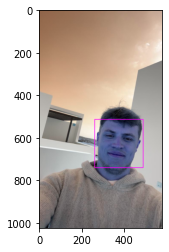

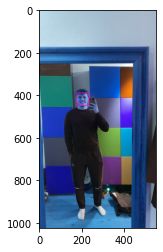

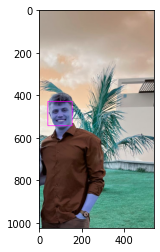

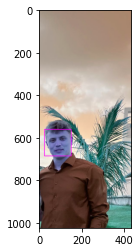

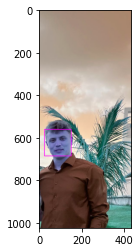

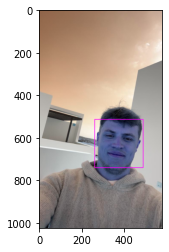

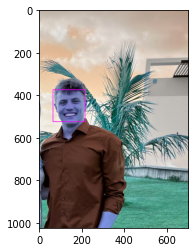

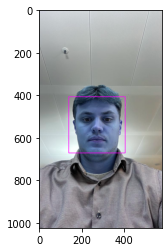

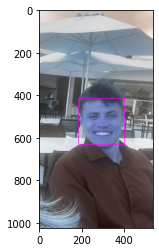

---Photo skipped---



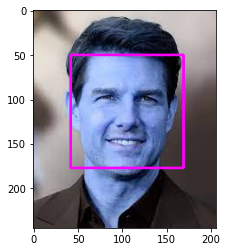

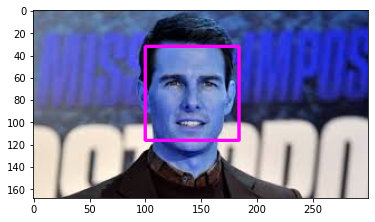

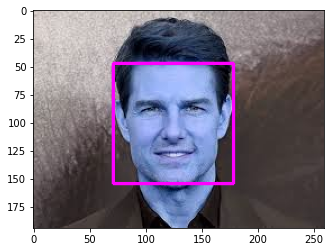

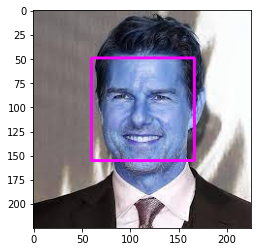

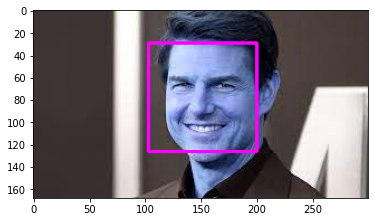

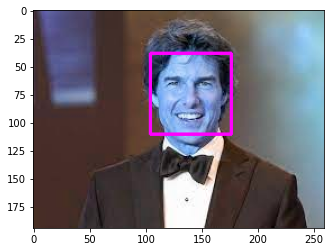

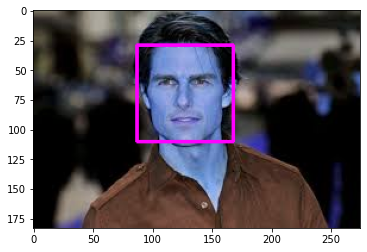

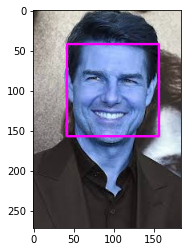

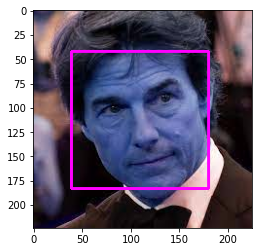

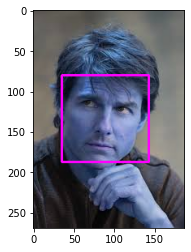

---Photo skipped---



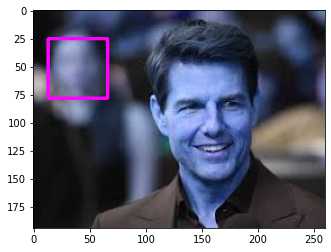

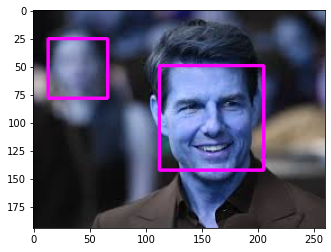

In [19]:
import cv2
import os
import pickle
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

dataset_folder_name = 'dataset_cnn'

# dimension of images
image_width = 224
image_height = 224

# for detecting faces
facecascade = cv2.CascadeClassifier('data/cascades/haarcascade_frontalface_default.xml')

# set the directory containing the images
images_dir = os.path.join(".", dataset_folder_name)

current_id = 0
label_ids = {}

# iterates through all the files in each subdirectories
for root, _, files in os.walk(images_dir):
    for file in files:
        if file.endswith("png") or file.endswith("jpg") or file.endswith("jpeg"):
            # path of the image
            path = os.path.join(root, file)

            # get the label name (name of the person)
            label = os.path.basename(root).replace(" ", ".").lower()

            # add the label (key) and its number (value)
            if not label in label_ids:
                label_ids[label] = current_id
                current_id += 1

            # load the image
            imgtest = cv2.imread(path, cv2.IMREAD_COLOR)
            image_array = np.array(imgtest, "uint8")

            # get the faces detected in the image
            faces = facecascade.detectMultiScale(imgtest,
            scaleFactor=1.2, minNeighbors=5)

            # if not exactly 1 face is detected, skip this photo
            if len(faces) != 1:
                print(f'---Photo skipped---\n')
           

            # save the detected face(s) and associate
            # them with the label
            for (x_, y_, w, h) in faces:

                # draw the face detected
                face_detect = cv2.rectangle(imgtest,
                        (x_, y_),
                        (x_+w, y_+h),
                        (255, 0, 255), 2)
                plt.imshow(face_detect)
                plt.show()

                # resize the detected face to 224x224
                size = (image_width, image_height)

                # detected face region
                roi = image_array[y_: y_ + h, x_: x_ + w]

                # resize the detected head to target size
                resized_image = cv2.resize(roi, size)
                image_array = np.array(resized_image, "uint8")

                # remove the original image
                os.remove(path)

                # replace the image with only the face
                im = Image.fromarray(image_array)
                im.save(path)


In [20]:
import os
import pandas as pd
import numpy as np
import tensorflow
from tensorflow import keras as keras

import matplotlib.pyplot as plt

from keras.layers import Dense, GlobalAveragePooling2D

from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model

from keras.optimizers import Adam

In [21]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_generator = \
    train_datagen.flow_from_directory(
'./dataset_cnn',
target_size=(224,224),
color_mode='rgb',
batch_size=32,
class_mode='categorical',
shuffle=True)

 


Found 24 images belonging to 2 classes.


In [22]:
train_generator.class_indices.values()
# dict_values([0, 1, 2])
NO_CLASSES = len(train_generator.class_indices.values())
NO_CLASSES

2

In [23]:
from keras_vggface.vggface import VGGFace 

base_model = VGGFace(include_top=True,
    model='vgg16',
    input_shape=(224, 224, 3))
base_model.summary()

print(len(base_model.layers))
# 26 layers in the original VGG-Face

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [24]:

base_model = VGGFace(include_top=False,
model='vgg16',
input_shape=(224, 224, 3))
base_model.summary()
print(len(base_model.layers))
# 19 layers after excluding the last few layers

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [25]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# final layer with softmax activation
preds = Dense(NO_CLASSES, activation='softmax')(x)

In [26]:
# create a new model with the base model's original input and the 
# new model's output
model = Model(inputs = base_model.input, outputs = preds)
model.summary()

# don't train the first 19 layers - 0..18
for layer in model.layers[:19]:
    layer.trainable = False

# train the rest of the layers - 19 onwards
for layer in model.layers[19:]:
    layer.trainable = True

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [27]:
model.compile(optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [28]:
model.fit(train_generator,
  batch_size = 1,
  verbose = 1,
  epochs = 20)

Epoch 1/20


1/1 [==============================] - 3s 3s/step - loss: 0.6897 - accuracy: 0.4583
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.5635 - accuracy: 1.0000
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.4112 - accuracy: 1.0000
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.2419 - accuracy: 1.0000
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.1144 - accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.0539 - accuracy: 1.0000
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.0303 - accuracy: 1.0000
Epoch 8/20
1/1 [==============================] - 2s 2s/step - loss: 0.0167 - accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 2s 2s/step - loss: 0.0076 - accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 2s 2s/step - loss: 0.0030 - accuracy: 1.0000
Epoch 11/20
1/1 [==============================] - 2s 2s/ste

In [29]:
# creates a HDF5 file
model.save(
    'transfer_learning_trained' +
    '_face_cnn_model.h5')

In [30]:
from keras.models import load_model

# deletes the existing model
del model

# returns a compiled model identical to the previous one
model = load_model(
    'transfer_learning_trained' +
    '_face_cnn_model.h5')

In [31]:
import pickle

class_dictionary = train_generator.class_indices
class_dictionary = {
    value:key for key, value in class_dictionary.items()
}
print(class_dictionary)

{0: 'luis', 1: 'tom cruise'}


In [32]:
# save the class dictionary to pickle
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, 'wb') as f: pickle.dump(class_dictionary, f)

In [33]:
import cv2
import os
import pickle
import numpy as np
import pickle

from PIL import Image
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras_vggface import utils

# dimension of images
image_width = 224
image_height = 224

# load the training labels
face_label_filename = 'face-labels.pickle'
with open(face_label_filename, "rb") as \
    f: class_dictionary = pickle.load(f)

class_list = [value for _, value in class_dictionary.items()]
print(class_list)


['luis', 'tom cruise']


In [34]:
from PIL import Image
import numpy as np
import cv2
import pickle
from keras.models import load_model

# for face detection
face_cascade = cv2.CascadeClassifier(
    'data/cascades/haarcascade_frontalface_default.xml')

# resolution of the webcam
screen_width = 1280       # try 640 if code fails
screen_height = 720

# size of the image to predict
image_width = 224
image_height = 224

# load the trained model
model = load_model('transfer_learning_trained_face_cnn_model.h5')

# the labels for the trained model
with open("face-labels.pickle", 'rb') as f:
    og_labels = pickle.load(f)
    labels = {key:value for key,value in og_labels.items()}
    print(labels)

# default webcam
stream = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    (grabbed, frame) = stream.read()
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # try to detect faces in the webcam
    faces = face_cascade.detectMultiScale(
        rgb, scaleFactor=1.3, minNeighbors=5)

    # for each faces found
    for (x, y, w, h) in faces:
        roi_rgb = rgb[y:y+h, x:x+w]

        # Draw a rectangle around the face
        color = (255, 0, 0)
        stroke = 2
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, stroke)

        # resize the image
        size = (image_width, image_height)
        resized_image = cv2.resize(roi_rgb, size)
        image_array = np.array(resized_image, "uint8")
        img = image_array.reshape(1,image_width,image_height,3) 
        img = img.astype('float32')
        img /= 255

        # predict the image
        predicted_prob = model.predict(img)
        confidence = round(predicted_prob[0].max() * 100, 2)

        # Display the label
        font = cv2.FONT_HERSHEY_SIMPLEX
        name = labels[predicted_prob[0].argmax()]
        color = (255, 0, 0)
        stroke = 2
        cv2.putText(frame, f'{name}', (x+5,y-5),
            font, 1, color,  stroke, cv2.LINE_AA)
        cv2.putText(frame, f'{confidence}', (x+5,y+h-5),
            font, 1, color,  stroke, cv2.LINE_AA)
    # Show the frame
    cv2.imshow("Image", frame)
    k = cv2.waitKey(10) & 0xff # Press 'ESC' for exiting 
    if k == 27:
        break      

# Cleanup
stream.release()
cv2.waitKey(1)
cv2.destroyAllWindows()
cv2.waitKey(1)



{0: 'luis', 1: 'tom cruise'}
1/1 [==============================] - 0s 118ms/step


-1